# 異常檢測

In [2]:
import numpy as np
import struct

# 讀取心電圖資料的函式

In [3]:
def read_ekg_data(input_file):
    with open(input_file, 'rb') as input_file:
        data_raw = input_file.read()
    n_bytes = len(data_raw)
    n_shorts = n_bytes/2
    unpack_string = '<%dh' % n_shorts
    data_shorts = np.array(struct.unpack(unpack_string,
    data_raw)).astype(float)
    return data_shorts

# 畫圖 大概看長怎樣

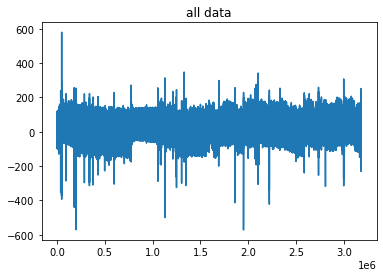

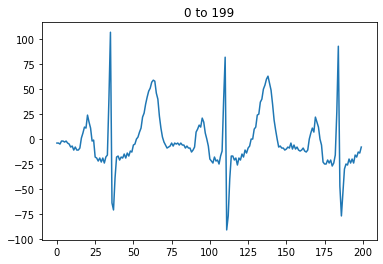

In [4]:
#讀取dat資料 以一維陣列存放
data = read_ekg_data('a02.dat')
#draw
import matplotlib.pyplot as plt
x = range(0,len(data))
y = data[:]
plt.plot(x, y)    #繪製折線圖all
plt.title('all data')
plt.show()
x = range(0,200)
y = data[0:200]
plt.plot(x, y)    #繪製折線圖前200
plt.title('0 to 199')
plt.show()

# 利用窗格(sliding window)對初始資料取樣

In [5]:
#秀出取樣結果的函式
def plot_waves(waves,step):
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100,150])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    plt.tight_layout()
    plt.show()

In [6]:
#slide_window
def sampling_data(data, leg_size, window_size):
    samples = []
    for pos in range(0,len(data),int(leg_size)):
        if pos+int(window_size) > len(data):
            break
        else:
            samples.append(data[pos:pos+int(window_size)])
    return samples

Produce 485 waveform segments


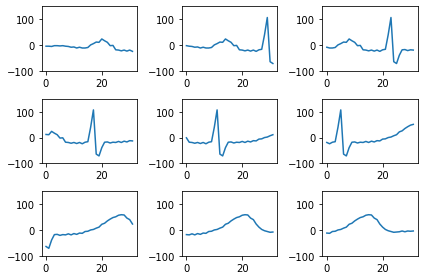

In [7]:
ekg_data = data[0:1000]
window_len = 32 #窗格大小
slide_len = 2 #步長
#segments: 列表(儲存每一步窗格所取樣的資料)
segments = sampling_data(ekg_data, slide_len, window_len)
print("Produce %d waveform segments" % len(segments))
plot_waves(segments, step=3)

# 利用K-MEANS針對每個窗格資料分群

分群後中心點樣本


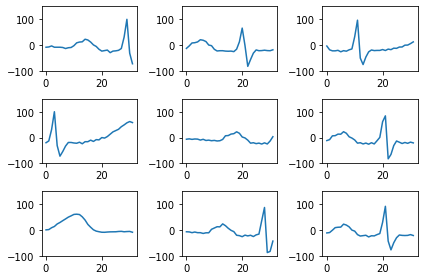

In [8]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=150) #分成150群
clusterer.fit(segments)
print('分群後中心點樣本')
plot_waves(clusterer.cluster_centers_, step=15)

In [12]:
#準備測試資料
slide_len = window_len/2
test_segments = sampling_data(ekg_data,slide_len,window_len)
test_segment = np.copy(test_segments[0])
test_segment = np.reshape(test_segment,(1,window_len))
#print(test_segment)

[[ -4.  -4.  -5.  -2.  -2.  -3.  -2.  -4.  -5.  -8.  -7. -11.  -8. -11.
  -11.  -9.   1.   6.  12.  11.  24.  17.  11.  -2.  -1. -18. -19. -22.
  -19. -23. -19. -24.]]


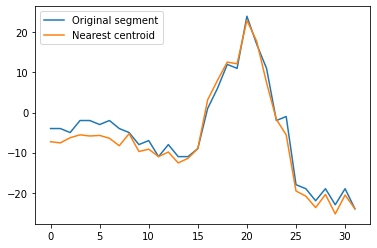

In [14]:
#與測試資料最接近的中心點
centroids = clusterer.cluster_centers_ #取出所有中心點
segment = np.reshape(test_segment,(1,window_len))
nearest_centroid_idx = clusterer.predict(segment)[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx]) #與segment最接近的中心點
segment = segment.reshape(-1)
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

In [43]:
#重建資料函式
def reconstruct( data,clusterer, window_len,window=np.array([1 for i in range(window_len)])):
    window_len = int(window_len)
    slide_len = window_len/2
    segments = sampling_data(data, slide_len, window_len)
    reconstructed_data = np.zeros(len(data))
    # 利用kmeans中心點，還原重建資料
    for segment_n, segment in enumerate(segments):
        segment *= window
        segment = np.reshape(segment,(1,window_len))
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])
        pos = int(segment_n*slide_len)
        reconstructed_data[pos:pos+int(window_len)] += nearest_match
    return reconstructed_data

實驗三
Maximum reconstruction error was 105.0
98th percentile of reconstruction error was 63.0


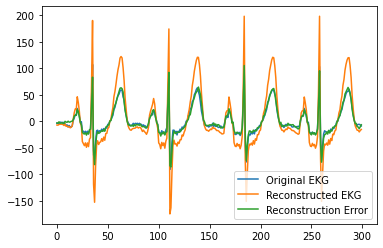

In [45]:
#秀出完整正常資料重建結果
reconstruction = reconstruct(ekg_data,clusterer,window_len)
n_plot_samples = 300
error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print('實驗三')
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)
plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

實驗三
Maximum reconstruction error was 58.2
98th percentile of reconstruction error was 10.2


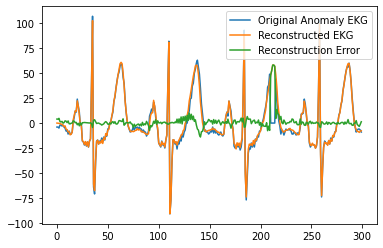

In [64]:
#模擬異常資料
ekg_data_anomalous = np.copy(ekg_data)
ekg_data_anomalous[210:215] = 0
recontruction = reconstruct(ekg_data_anomalous, clusterer,window_len)
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print('實驗三')
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)
plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original Anomaly EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

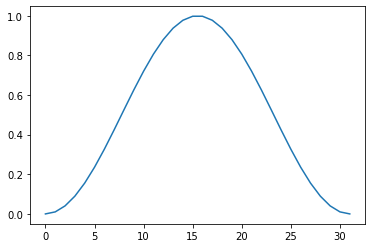

In [65]:
#設定窗格函數
line = np.linspace(0,np.pi,int(window_len))
window = np.sin(line)**2
plt.plot(window)
plt.show()

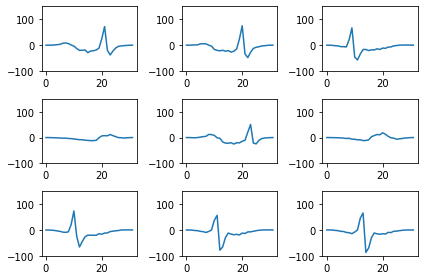

In [66]:
#利用K-MEANS針對每個窗格資料分群 + 窗格函數by上 作加權
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)
clusterer_window = KMeans(n_clusters=150)
clusterer_window.fit(windowed_segments)
plot_waves(clusterer_window.cluster_centers_, step=15)

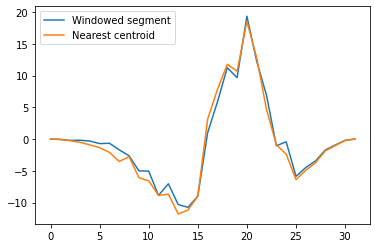

In [67]:
#看新中心點
centroids_window = clusterer_window.cluster_centers_
windowed_segment = test_segment * window
windowed_segment = np.reshape(windowed_segment,(1,window_len))
nearest_centroid_window_idx = clusterer_window.predict(windowed_segment)[0]
nearest_centroid_window = np.copy(centroids_window[nearest_centroid_window_idx])
windowed_segment = windowed_segment.reshape(-1)
plt.figure()
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid_window, label="Nearest centroid")
plt.legend()
plt.show()

實驗四
Maximum reconstruction error was 13.9
98th percentile of reconstruction error was 7.1


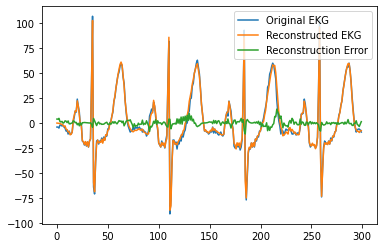

In [68]:
#SHOW出重建結果
reconstruction = reconstruct(ekg_data,clusterer_window,window_len)
n_plot_samples = 300
error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print('實驗四')
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)
plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

實驗四
Maximum reconstruction error was 94.3
98th percentile of reconstruction error was 59.0


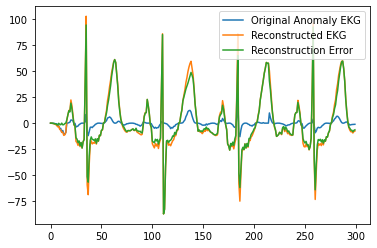

In [69]:
#秀出完整異常資料重建結果
recontruction = reconstruct(ekg_data_anomalous, clusterer,window_len,window=window)
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print('實驗四')
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)
plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original Anomaly EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()